**Import required libraries for the FastAI model**

In [1]:
from fastai.imports import *
from fastai.vision.all import *
from fastai.vision.widgets import *

**Set the path to the training dataset**

In [2]:
PATH = "/kaggle/input/testset/data/train"
#os.chdir(PATH)
#os.listdir()
from PIL import Image
import numpy

**Load an example image from the dataset and display it**

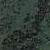

In [3]:
im = Image.open(PATH+"/no_pools/img1194.jpg")
im

**Define the DataBlock for the pool detection task**

In [4]:
poolDetection = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(50))

**Create dataloaders for the pool detection dataset**

In [5]:
dls = poolDetection.dataloaders(PATH)

**Display a batch of validation images**

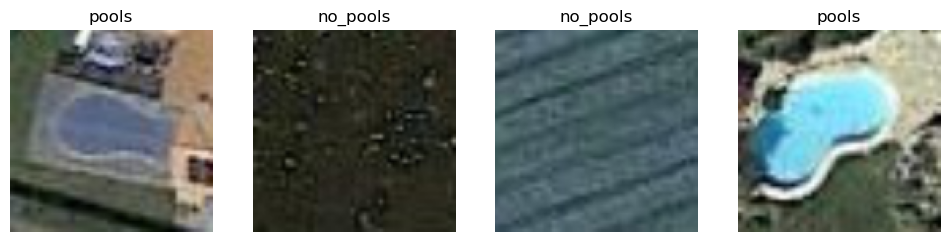

In [6]:
dls.valid.show_batch(max_n=4, nrows=1)

**Create a CNN learner using the ResNet18 architecture**

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

**Running the lerning rate finder to get the best suggested lerning rates and extract the suggested learning rate corresponding to the vallay for the loss curve**

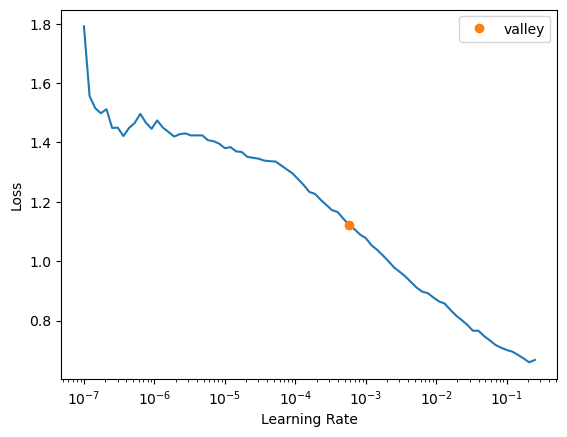

In [27]:
suggested_lrs = learn.lr_find()
lr_min = suggested_lrs.valley

**Setting the number of epochs for the fine tuning of the model, and then fine tune the model using the n_epochs and the suggested lerningrate we found over**

In [29]:
n_epochs = 7 # epochs you like to use
learn.fine_tune(n_epochs, base_lr=lr_min)

epoch,train_loss,valid_loss,error_rate,time
0,0.048388,0.163413,0.047794,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.039776,0.159061,0.045956,00:10
1,0.029042,0.155936,0.042279,00:10
2,0.019576,0.168870,0.042279,00:10
3,0.011769,0.173427,0.044118,00:10
4,0.009132,0.168994,0.044118,00:10
5,0.010925,0.176192,0.042279,00:10
6,0.006770,0.163132,0.036765,00:10


**Visualize the model's performance with a confusion matrix**

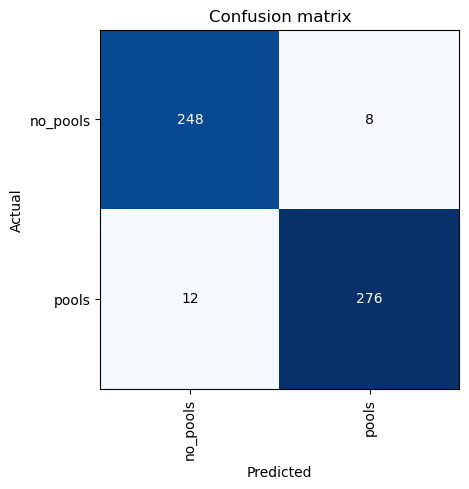

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**Display the top 5 losses**

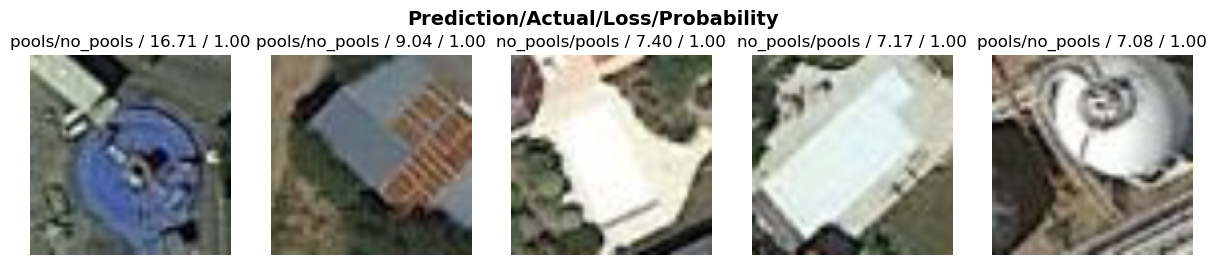

In [31]:
interp.plot_top_losses(5, nrows=1)

**Create an ImageClassifierCleaner for cleaning the dataset**

In [10]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Did not want to clean my dataset but by running this code bellow its possible

In [11]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

**Export the trained model**

In [12]:
learn.export('firstModel.pkl')